In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import textwrap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

In [2]:
# Q1

# handling of missing values

df = pd.read_csv("clean_kaggle_data_2020.csv")
df = df.iloc[1:]
del df['Time from Start to Finish (seconds)']
del df['Q24']
del df['Q24_buckets']
df_clean = df.dropna(axis=1) # columns with missing values are dropped

In [3]:
# converting categorical data into numerical data

# using one-hot encoding to convert features into numerical data
dummies_Q1 = pd.get_dummies(df_clean['Q1'], prefix='Q1')
dummies_Q2 = pd.get_dummies(df_clean['Q2'], prefix='Q2')
dummies_Q3 = pd.get_dummies(df_clean['Q3'], prefix='Q3')
dummies_Q4 = pd.get_dummies(df_clean['Q4'], prefix='Q4')
dummies_Q5 = pd.get_dummies(df_clean['Q5'], prefix='Q5')
dummies_Q6 = pd.get_dummies(df_clean['Q6'], prefix='Q6')
dummies_Q20 = pd.get_dummies(df_clean['Q20'], prefix='Q20')
dummies_Q21 = pd.get_dummies(df_clean['Q21'], prefix='Q21')
dummies_Q22 = pd.get_dummies(df_clean['Q22'], prefix='Q22')

tempDF = pd.concat([df_clean, dummies_Q1, dummies_Q2, dummies_Q3, dummies_Q4, dummies_Q5, dummies_Q6, dummies_Q20, dummies_Q21, dummies_Q22], axis=1)
tempDF = tempDF.drop(['Q1','Q2','Q3','Q4','Q5','Q6','Q20','Q21','Q22'],axis=1)

# Drop one of each of the dummy variables because its value is implied by the other dummy variable columns
df_clean2 = tempDF.drop(['Q1_70+','Q2_Prefer not to say','Q3_Other','Q4_I prefer not to answer','Q5_Other','Q6_I have never written code','Q20_10,000 or more employees','Q21_20+','Q22_I do not know'],axis=1)

for i in df_clean2.columns:
    df_clean2.rename(columns={i: textwrap.shorten(i, width=24, placeholder="...")}, inplace=True)

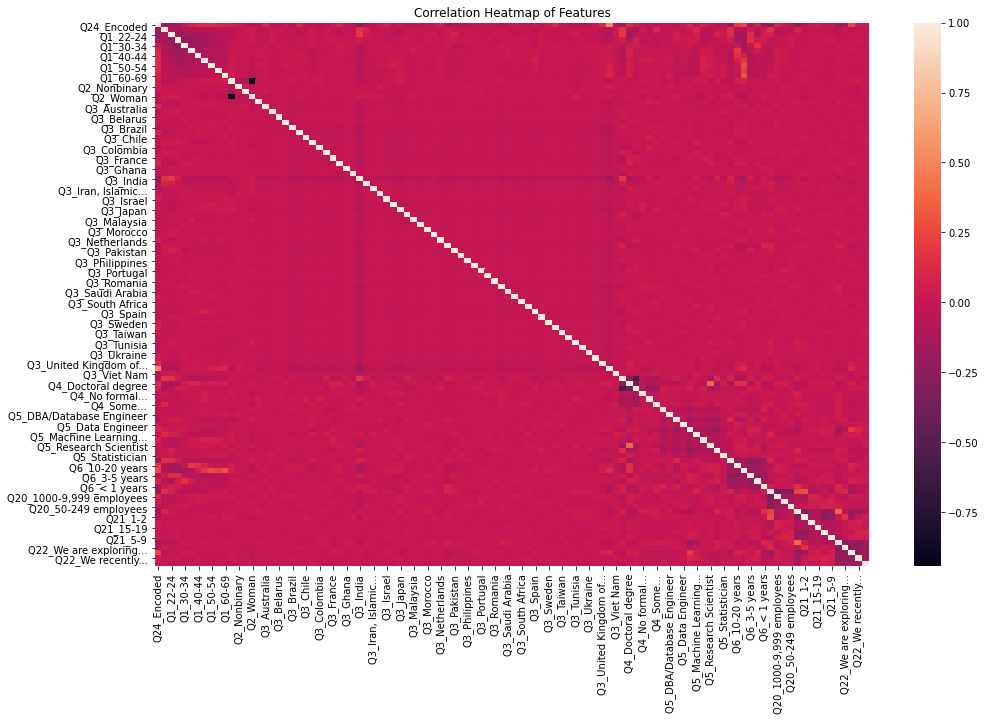

In [4]:
# Q2

# exploratory data analysis

#correlation heatmap
corr = df_clean2.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr)
plt.title('Correlation Heatmap of Features')
plt.show()

In [5]:
# finding the feature that is most related to yearly compensation
q24_correlation = corr[['Q24_Encoded']]
q24_correlation = q24_correlation.abs()
q24_correlation = q24_correlation.iloc[1:]
q24_correlation = q24_correlation.sort_values(by=['Q24_Encoded'], ascending=False)

print('The feature that is most related to yearly compensation is', q24_correlation.index[0])

The feature that is most related to yearly compensation is Q3_United States of...


In [6]:
# feature selection using backward elimination

df_features = df_clean2.drop(['Q24_Encoded'], axis=1)
selected_columns = df_features.columns

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05 # P-value of 0.05 was used
data_modeled, selected_columns = backwardElimination(df_clean2.iloc[:,1:].values, df_clean2.iloc[:,0].values, SL, selected_columns)

In [7]:
print('The following features were selected after performing backward elimination:')
print(selected_columns)
print('Total number of features selected:', selected_columns.shape[0])

The following features were selected after performing backward elimination:
Index(['Q1_18-21', 'Q1_22-24', 'Q1_25-29', 'Q1_30-34', 'Q1_35-39', 'Q1_40-44',
       'Q1_45-49', 'Q1_50-54', 'Q1_55-59', 'Q1_60-69', 'Q2_Man',
       'Q2_Nonbinary', 'Q3_Argentina', 'Q3_Australia', 'Q3_Bangladesh',
       'Q3_Belarus', 'Q3_Belgium', 'Q3_Brazil', 'Q3_Canada', 'Q3_Chile',
       'Q3_Colombia', 'Q3_Egypt', 'Q3_France', 'Q3_Germany', 'Q3_Greece',
       'Q3_India', 'Q3_Indonesia', 'Q3_Iran, Islamic...', 'Q3_Ireland',
       'Q3_Israel', 'Q3_Japan', 'Q3_Kenya', 'Q3_Malaysia', 'Q3_Mexico',
       'Q3_Morocco', 'Q3_Netherlands', 'Q3_Nigeria', 'Q3_Pakistan', 'Q3_Peru',
       'Q3_Philippines', 'Q3_Russia', 'Q3_Singapore', 'Q3_South Africa',
       'Q3_Spain', 'Q3_Sri Lanka', 'Q3_Sweden', 'Q3_Switzerland', 'Q3_Taiwan',
       'Q3_Turkey', 'Q3_Ukraine', 'Q3_United Arab Emirates',
       'Q3_United Kingdom of...', 'Q3_United States of...', 'Q3_Viet Nam',
       'Q4_Bachelor’s degree', 'Q4_Doctoral degree

In [8]:
target = pd.DataFrame()
target['Q24_Encoded'] = df_clean2.iloc[:,0]

features = pd.DataFrame(data = data_modeled, columns = selected_columns)

In [9]:
# split data into training and testing set with 70%-30% split

X = features
y = target['Q24_Encoded'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

In [10]:
# Q3 and Q4

# implementation of ordinal logistic regression model

# function inputs:
    # X_train_input is features dataset used to fit models
    # y_train_input is target dataset used to fit models
    # X_val_input is the data that we wish to classify
    # C_input is hyperparameter for inverse of regularization strength
    # penalty_input is hyperparameter for penalization
    
# function outputs:
    # bucket_probabilities is the probabilties matrix that shows the probability of each datapoint for each salary bucket
    # predictions_array is the predictions matrix that shows the predicted salary bucket of each datapoint


def ordinalLogisticRegression(X_train_input, X_val_input, y_train_input, C_input, penalty_input):
    
    probability_df = pd.DataFrame()
    # 14 iterations of binary classification, since there are 15 total possible classes
    for iteration in range(14):
        X_train_copy, X_val_copy, y_train_copy = X_train_input.copy(), X_val_input.copy(), y_train_input.copy()
        
        if iteration == 0:
            probability_list = []
            # set all class labels greater than iteration number to 1, else set to 0
            for index, value in y_train_copy.items():
                if value>0:
                    y_train_copy[index] = 1
            
            model = LogisticRegression(C=C_input, penalty=penalty_input, solver = 'saga')
            model.fit(X_train_copy, y_train_copy)
            probabilities = model.predict_proba(X_val_copy)
            
            for i in range(probabilities.shape[0]):
                probability_list.append(probabilities[i][0])
    
            probability_df[str(1)] = probability_list
        
        else:
            probability_list = []
            # set all class labels greater than iteration number to 1, else set to 0
            for index, value in y_train_copy.items():
                if value>iteration:
                    y_train_copy[index] = 1
                else:
                    y_train_copy[index] = 0
            
            model = LogisticRegression(C=C_input, penalty=penalty_input, solver = 'saga')
            model.fit(X_train_copy, y_train_copy)
            probabilities = model.predict_proba(X_val_copy)
            
            for i in range(probabilities.shape[0]):
                probability_list.append(probabilities[i][0])
    
            probability_df[str(iteration+1)] = probability_list
    # probability_df contains the cumulative probabilities for the 15 different salary buckets
    probability_df[str(15)] = [1]*probabilities.shape[0]
    
    probabilityDiff_df = pd.DataFrame()
    probabilityDiff_df['1'] = probability_df['1']
    # probabilityDiff_df is the probability table which contains the probabilities of each of the different salary buckets
    # obtained by subtracting each column of the cumulative probabilities table from the previous column
    for i in range(1,15):
        probabilityDiff_df[str(i+1)] = probability_df[str(i+1)] - probability_df[str(i)]
    # predictions_array is the predictions matrix that shows the predicted salary bucket of each datapoint
    predictions_array = probabilityDiff_df.idxmax(axis=1)
    
    for i in range(probabilities.shape[0]):
        predictions_array[i] = int(predictions_array[i]) - 1
        
    predictions_array = predictions_array.to_numpy()
    predictions_array = predictions_array.astype(int)
    
    bucket_probabilities = pd.DataFrame()
    for i in range(15):
        bucket_probabilities['salary bucket ' + str(i)] = probabilityDiff_df[str(i+1)]
        
    return(bucket_probabilities, predictions_array)
    

In [11]:
# hyerparameter tuning using 10-fold cross validation

# the two hyperparameters I chose to tune were C (inverse of regularization strength) and penalty type (l1 or l2)

# to re-run the cross validation in this cell, please un-comment the code below

# kfold = KFold(n_splits=10)
# kfold.get_n_splits(X_train)

# best_params = {}
# ACC = 0
# best_f1 = 0


# for C in [0.01,0.1,1]:
#     for penalty in ['l1','l2']:
        
#         f1_matrix = np.zeros(10)
#         ACC_matrix = np.zeros(10)
#         np_idx = 0
#         print('C =', C, ', penalty =', penalty)
        
#         for train_idx, test_idx in kfold.split(X_train):
#             X_train_input, X_val_input = X_train.values[train_idx], X_train.values[test_idx]
#             y_train_input, y_val_input = y_train.values[train_idx], y_train.values[test_idx]
#             X_train_input = pd.DataFrame(data=X_train_input, columns=list(X_train.columns))
#             X_val_input = pd.DataFrame(data=X_val_input, columns=list(X_train.columns))
#             y_train_input = pd.Series(y_train_input)
#             y_val_input = pd.Series(y_val_input)
#             # calling ordinal logistic regression function to get predictions matrix
#             probabilities_matrix, predictions = ordinalLogisticRegression(X_train_input, X_val_input, y_train_input, C, penalty)

#             f1_val = f1_score(y_val_input, predictions, average='micro')
            
#             f1_matrix[np_idx] = f1_val
            
#             TN = confusion_matrix(y_val_input, predictions)[0][0]
#             FP = confusion_matrix(y_val_input, predictions)[0][1]
#             FN = confusion_matrix(y_val_input, predictions)[1][0]
#             TP = confusion_matrix(y_val_input, predictions)[1][1]
#             total = TN + FP + FN + TP
#             ACC = (TP + TN) / float(total)
#             ACC_matrix[np_idx] = ACC
            
#             np_idx += 1
            
#             print('Fold', np_idx, ": accuracy:", ACC*100, "%", ', F1-score:', f1_val*100, "%")
        
#         print('\n')
        
#         if np.mean(f1_matrix) > best_f1:
#             best_C = C
#             best_penalty = penalty
#             best_params = {'C':C, 'penalty':penalty}
#             best_f1 = np.mean(f1_matrix)
#             best_accuracy = ACC


In [12]:
# after running cross-validation from the previous cell, the following optimal parameters were found:
best_params = {'C':0.1, 'penalty':'l2'}
ACC_matrix = np.array([0.76486486, 0.81016043, 0.84383562, 0.78688525, 0.7890411 ,0.81369863, 0.79479769, 0.77944862, 0.78333333, 0.7965616 ])
best_accuracy = 0.7960893854748603
best_f1 = 0.4451398135818908
best_C = 0.1
best_penalty = 'l2'
# when re-running the cross validation in previous cell, please comment the above 6 lines of code

print(best_params)
print('best accuracy:', best_accuracy*100, '%, variance =', np.var(ACC_matrix*100), '%')
print('best F1 score:', best_f1*100, '%')
print('The optimal log model uses C=',best_C,'and penalty =',best_penalty)

{'C': 0.1, 'penalty': 'l2'}
best accuracy: 79.60893854748603 %, variance = 4.338371193524006 %
best F1 score: 44.51398135818908 %
The optimal log model uses C= 0.1 and penalty = l2


In [18]:
# Q5

# model performance on test set

# from cross-validation, we determined that using C=0.01 and l2 penalty gives the best F1-Score
probabilities_matrix_test, predictions_test = ordinalLogisticRegression(X_train, X_test, y_train, 0.1, 'l2')

TN = confusion_matrix(y_test, predictions_test)[0][0]
FP = confusion_matrix(y_test, predictions_test)[0][1]
FN = confusion_matrix(y_test, predictions_test)[1][0]
TP = confusion_matrix(y_test, predictions_test)[1][1]
total = TN + FP + FN + TP
ACC_test = (TP + TN) / float(total)
                        
f1_val_test = f1_score(y_test, predictions_test, average='micro')

print('accuracy of test set:', ACC_test*100, '%')
print('F1-score of test set:', f1_val_test*100, '%')

accuracy of test set: 80.68833652007649 %
F1-score of test set: 43.18111214662939 %


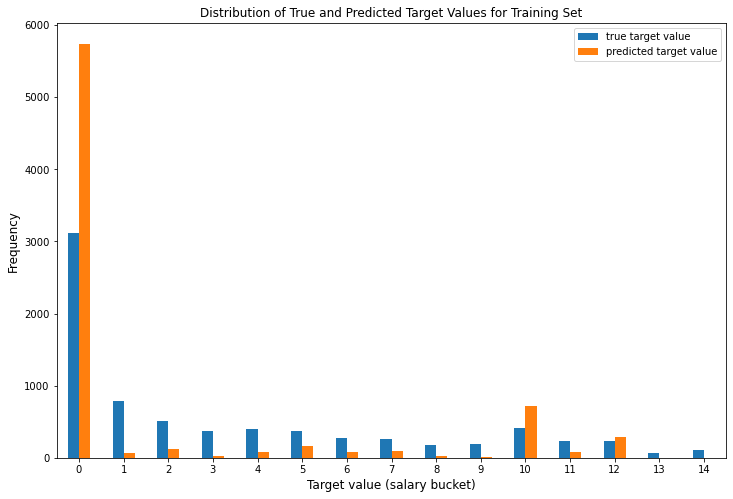

In [14]:
# plot of distribution of true and predicted target variable values for training set

probabilities_matrix_train, predictions_train = ordinalLogisticRegression(X_train, X_train, y_train, 0.1, 'l2')

df_true = pd.DataFrame({"true target value":y_train.value_counts().sort_index(),"predicted target value":pd.Series(predictions_train).value_counts().sort_index()})
ax = df_true.plot.bar(rot=0, figsize=(12,8))
plt.title('Distribution of True and Predicted Target Values for Training Set', fontsize=12)
ax.set_xlabel("Target value (salary bucket)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()

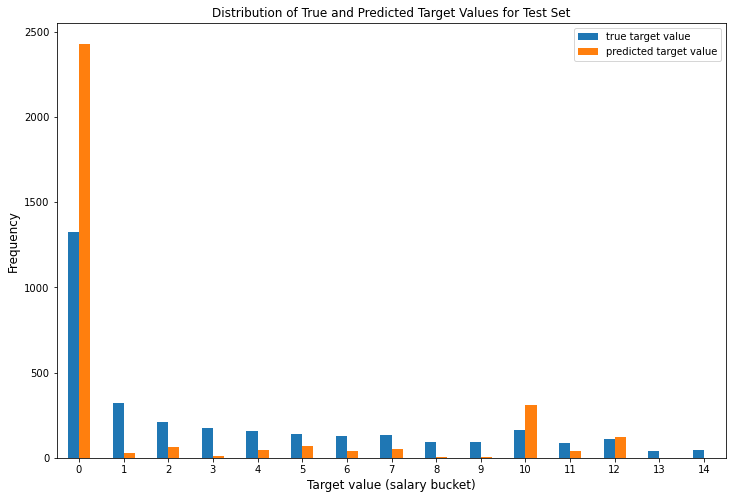

In [15]:
# plot of distribution of true and predicted target variable values for test set

df_true = pd.DataFrame({"true target value":y_test.value_counts().sort_index(),"predicted target value":pd.Series(predictions_test).value_counts().sort_index()})
ax = df_true.plot.bar(rot=0, figsize=(12,8))
plt.title('Distribution of True and Predicted Target Values for Test Set', fontsize=12)
ax.set_xlabel("Target value (salary bucket)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.show()